# 🏗️Import Necessary Libraries

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The code imports various data science libraries, including TensorFlow and scikit-learn, and defines a neural network model using the EfficientNet architecture. It also includes system libraries for handling file paths and metrics for evaluating model performance. Additionally, it sets up various callbacks and optimizers to optimize the training process.</p>

In [1]:
#!pip install tensorflow
#!pip install opencv-python
#!pip install cv2
# !pip install BIRDS
# pip install --upgrade --user pip
# !pip install google.colab
# !pip install itables
# !pip install dill


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
import pickle
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import birds_utils as birds
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import dill
import copy


# Principle parameters

In [3]:
# principle parameters
BATCH_SIZE = 32 # size of batch (The ImageDataGenerator objects generate batches of tensor image data with real-time data augmentation)
TARGET_SIZE = (224, 224)    # size of pictures (used by the ImageDataGenerator objects)
N_LABELS = 100    # number of lables for analysis ('all will keep all labels)
N_EPOCHS = 5 # number of epochs for the traning NN
N_SAMPLES_PER_LABEL = 'all' # number of sampels per label that are kept for training ('all' will keep all samples)
N_EPOCHS_PATIENCE = 20
AUGMENTATON = False
BASE_PATH = './models/'
if (AUGMENTATON):
    RUN_NAME = f'birds_augmentation_N_LABELS_{N_LABELS}'
else:
    RUN_NAME = f'birds_no_augmentation_N_LABELS_{N_LABELS}'
label_count_thresh = 50
fig_width = 8

MODEL_PATH = f'{BASE_PATH}{RUN_NAME}/'
if (not os.path.exists(MODEL_PATH)):
    os.makedirs(MODEL_PATH)



# 🤙Create helper functions

In [4]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [5]:
# import urllib.request

# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# filename = "helper_functions.py"
# urllib.request.urlretrieve(url, filename)

# 📥Load and Transform Data

In [6]:
project_dir = '.'
image_df_full = birds.load_data(project_dir).drop_duplicates() 
image_df_full = image_df_full.sample(frac=1, random_state=42)  # frac=1 means the entire DataFrame is sampled




In [7]:
# filter out all the lables with less than label_count_thresh
boolean_vec = image_df_full.groupby('label').count()['Filepath'].values>=label_count_thresh
labels_to_keep = image_df_full.groupby('label').count()[boolean_vec]
image_df = birds.filter_df(image_df_full,labels=list(labels_to_keep.index))

In [8]:
if (N_LABELS=='all'):
    N_LABELS = len(birds.get_labels(image_df))
    
lables = list(birds.get_labels(image_df)[0:N_LABELS])
image_df = birds.filter_df(image_df,labels=lables)
image_df = birds.filter_df(image_df,N_samples_per_label=N_SAMPLES_PER_LABEL)

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
labels = image_df['label'].tolist() # Make sure this is your training data labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


# 🔭Visualizing images from the dataset

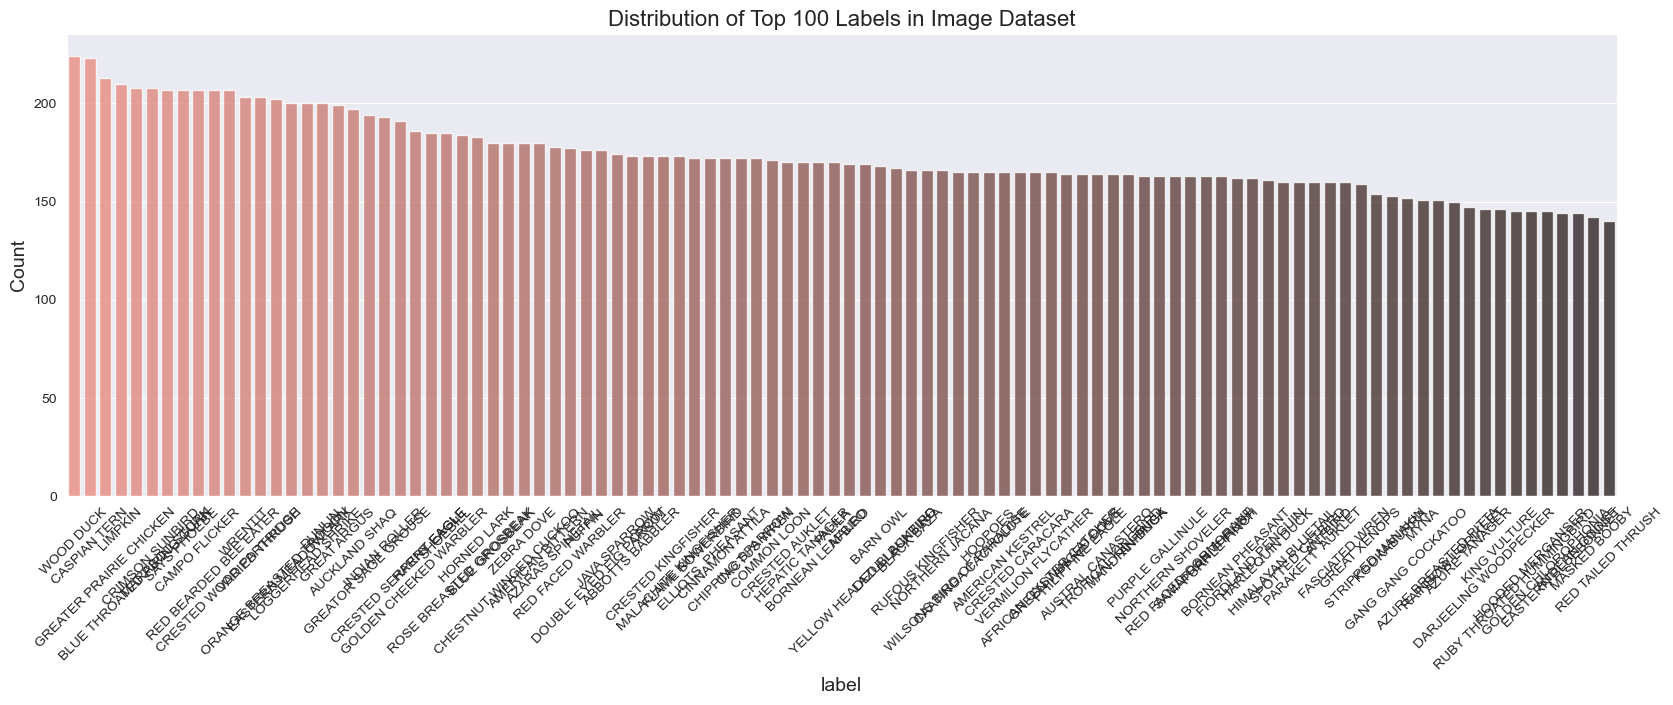

In [9]:
# birds.test_df
# plot all images of a label
# # plot the 1'st 5 instances of a labelbirds.plot_label_images(test_df,label=birds.get_labels(test_df)[1])

# birds.plot_label_images(test_df,label=birds.get_labels(test_df)[1],N=5)

# # plot tests according to idx
# birds.plot_label_tests(test_df,idx=[1,9])

birds.plot_labels_count(image_df)

# Data Splitting into 3 ImageDataGenerators


In [10]:
# Separate in train and test data
train_obj_dic = {'name':'train'}
val_obj_dic = {'name':'val'}
test_obj_dic = {'name':'test'}

# we saw that the df was balanced so we added stratify=image_df['label']

train_df_pre, test_obj_dic['df'] = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42,stratify=image_df['label'])
train_obj_dic['df'], val_obj_dic['df'] = train_test_split(train_df_pre, test_size=0.2, shuffle=True, random_state=42,stratify=train_df_pre['label'])


In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [12]:

# Split the data into three categories.
train_obj_dic['images_obj'] = train_generator.flow_from_dataframe(
    dataframe=train_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
)

val_obj_dic['images_obj'] = val_generator.flow_from_dataframe(
    dataframe=val_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
)

test_obj_dic['images_obj'] = test_generator.flow_from_dataframe(
    dataframe=test_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 11105 validated image filenames belonging to 100 classes.
Found 2777 validated image filenames belonging to 100 classes.
Found 3471 validated image filenames belonging to 100 classes.


# Image Augemntation

## Define the image augmentation object

In [13]:
# Data Augmentation Step
RANDOM_FLIP = 'horizontal'
RANDOM_ROTATION = 0.1
RANDOM_ZOOM = 0.9
RANDOM_CONTRAST = 0.1

augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip(RANDOM_FLIP),
#   layers.experimental.preprocessing.RandomRotation(RANDOM_ROTATION),
  layers.experimental.preprocessing.RandomZoom(RANDOM_ZOOM),
#   layers.experimental.preprocessing.RandomContrast(RANDOM_CONTRAST),
])

## 🚄Observing augemented images

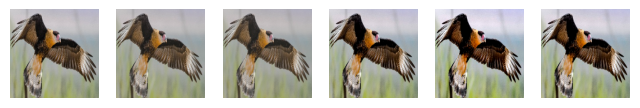

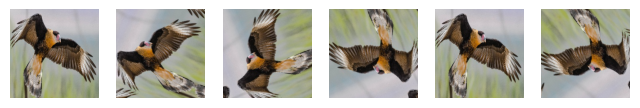

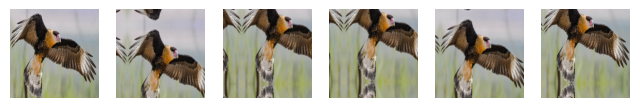

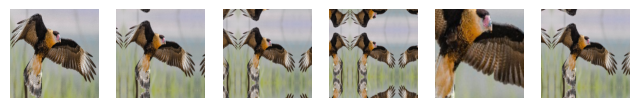

In [82]:
ind = 3
img = birds.get_image(image_df,idx=29633)
import copy


num_cols=6


operation_dic = {
                    'RandomContrast':[1.0,1.0],
                    'RandomRotation':[0,180],
                    'RandomTranslation':[0.1,0.5],  
                    'RandomZoom':[0.9,0.9]                   
                }

num_rows = len(operation_dic.keys())
fig_width = 8


for opration in list(operation_dic.keys()):
    val_vec = np.linspace(operation_dic[opration][0],operation_dic[opration][1],num_cols)
    fig, axes = plt.subplots(1, num_cols, figsize=(fig_width, fig_width*num_rows/num_cols) )
    c=0
    for ind, ax in enumerate(axes.flat):
        img = copy.deepcopy(birds.get_image(image_df[:],idx=29633))
        if (c==0):
            ax.imshow(img)
            ax.axis('off')
            c=1
            continue

        if (opration=='RandomContrast'):
            augment = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows])
            ])
        elif (opration=='RandomRotation'):
            augment = tf.keras.Sequential([
                # layers.experimental.preprocessing.RandomRotation([val_vec[ind%num_rows],val_vec[ind%num_rows]])
                layers.experimental.preprocessing.RandomRotation(factor=(0,val_vec[ind%num_rows]))
            ])
            
        elif (opration=='RandomTranslation'):
            augment = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomTranslation(height_factor = val_vec[ind%num_rows],width_factor = val_vec[ind%num_rows])
            ])

        elif (opration=='RandomZoom'):
            augment = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomZoom(val_vec[ind%num_rows])
            ])



        # Example: Replace this line with your image loading logic
        img_array = np.expand_dims(img, axis=0)

        augmented_image = augment(np.expand_dims(img, 0)).numpy().squeeze() / 255

        # Display the augmented image in the current subplot
        ax.imshow(augmented_image)
        ax.axis('off')

        # augment = tf.keras.Sequential([
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),                
        #     ])


    plt.show()


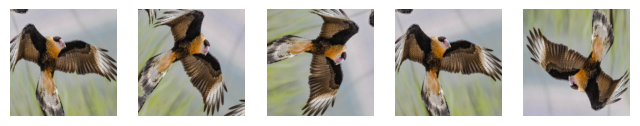

In [58]:
ind = 3
img = birds.get_image(image_df,idx=29633)


num_cols=5


operation_dic = {
                    'RandomContrast':[1.0,1.0],
                    # 'RandomRotation':[0,180],
                    # 'RandomTranslation':[0.1,0.5],  
                    # 'RandomZoom':[0.9,0.9]                   
                }

num_rows = len(operation_dic.keys())
fig_width = 8
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_width*num_rows/num_cols) )


for ind, ax in enumerate(axes.flat):
    del(augment)
    img = birds.get_image(image_df,idx=29633)

    augment = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows])
    ])
    

    augment = tf.keras.Sequential([
        # layers.experimental.preprocessing.RandomRotation([val_vec[ind%num_rows],val_vec[ind%num_rows]])
        layers.experimental.preprocessing.RandomRotation(factor=(0,val_vec[ind%num_rows]))
    ])

    img_array = np.expand_dims(img, axis=0)

    augmented_image = augment(np.expand_dims(img, 0)).numpy().squeeze() / 255

    # Display the augmented image in the current subplot
    ax.imshow(augmented_image)
    ax.axis('off')
#a
plt.show()   


# 🤹Training the model
<div style="background-color:#fff1cc; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em"



In [15]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [16]:
# Create checkpoint callback
checkpoint_path = f'{MODEL_PATH}/{RUN_NAME}_check_point.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = N_EPOCHS_PATIENCE,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [17]:
inputs = pretrained_model.input
inputs.__dict__['_type_spec']

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')

In [18]:

if (AUGMENTATON):
    inputs = pretrained_model.input
    x = augment(inputs)
    x = pretrained_model(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.45)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.45)(x)

else:
    inputs = pretrained_model.input
    # x = augment(inputs)
    x = Dense(128, activation='relu')(pretrained_model.output)
    x = Dropout(0.45)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.45)(x)
    
outputs = Dense(N_LABELS, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [19]:
file_name = f'{MODEL_PATH}/{RUN_NAME}.pkl'
print(file_name)

./models/birds_no_augmentation_N_LABELS_100//birds_no_augmentation_N_LABELS_100.pkl


In [20]:
model_file_path = f'{MODEL_PATH}/{RUN_NAME}.keras'
history_file_path = f'{MODEL_PATH}/{RUN_NAME}.pkl'

if os.path.exists(model_file_path):
# load model    
    print(f'loading {RUN_NAME} and related history')
    model = keras.models.load_model(model_file_path)
    # Later, you can load the history object
# load history   
    with open(history_file_path, 'rb') as file:
        history = pickle.load(file)
        history = pd.DataFrame({'history':history})

else:
    if os.path.exists(checkpoint_path):
        print (f'loading check point from {checkpoint_path}')
        model = keras.models.load_model(checkpoint_path)
    
    history = model.fit(
        train_obj_dic['images_obj'],
        steps_per_epoch=len(train_obj_dic['images_obj']),
        validation_data=val_obj_dic['images_obj'],
        validation_steps=len(val_obj_dic['images_obj']),
        epochs=N_EPOCHS,
        class_weight=class_weights_dict,
        callbacks=[
            early_stopping,
            # birds.create_tensorboard_callback("training_logs",
            #                             "bird_classification"),
            checkpoint_callback,
            reduce_lr
        ]
    )

    model.save(model_file_path)
    with open(history_file_path, 'wb') as file:
        pickle.dump(history.history, file)



loading birds_no_augmentation_N_LABELS_100 and related history


# ✔️Model Evaluation
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:10px; font-family:verdana; line-height: 1.7em"

## 📉Visualizing loss curves

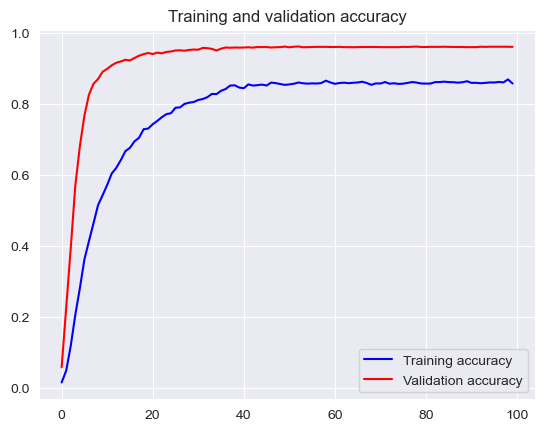

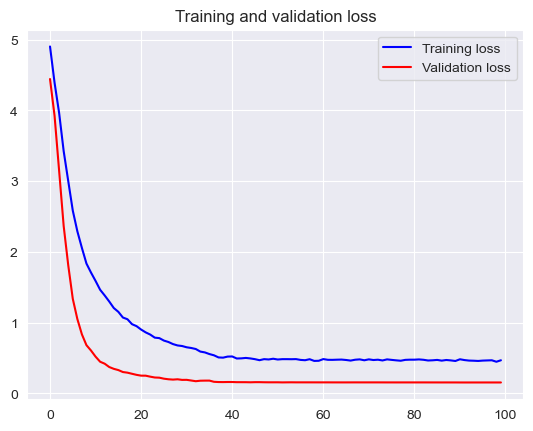

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the Test Data

In [27]:
def plot_images(df,label=None,N=None,idx=None,fig_width=25,n_cols=8):
  if (df.shape[0]==0):
    print('df is empty')
    return

  font_size=fig_width*3/n_cols
  if (label != None):
    idx = get_label_idx(df,label)
    if (N is None):
      N = image_df[image_df['label']==label].shape[0]
      idx = idx[0:N+1]

  elif (idx is not None):
      N = len(idx)

  N_image_in_fig = N

  n_rows = int(np.ceil(N_image_in_fig/n_cols))
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(fig_width, fig_width*n_rows/n_cols+2),
                      subplot_kw={'xticks': [], 'yticks': []})

  for ind, ax in enumerate(axes.flat):
    if (ind<N):
      ax.imshow(plt.imread(df.loc[idx[ind]].Filepath))
      if 'predicted_label' not in df.columns:
        ax.set_title(f'{df.loc[idx[ind]].label} {idx[ind]}',fontsize=font_size)
      else:
        if df['status'].iloc[ind]:
          color = "green"
        else:
          color = "red"

        ax.set_title(f"index:{df.index[ind]}\nTrue: {df.label.iloc[ind]}\nPredicted: {df.predicted_label.iloc[ind]}", color=color,fontsize=font_size)

  # plt.subplots_adjust(wspace=0)
  plt.tight_layout(pad=0.5)
  plt.show()


In [23]:
from birds_utils import filter_df
# from birds_utils import plot_images
from birds_utils import plot_label_images

In [37]:
def plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=0,n_cols=5,N=5,false_ind=0,false_label = None):
    df = obj_dic_stack['train']['classification_report'].sort_values('f1-score')

    if (ana_label is None):
        ana_label = df.index[ana_label_ind]

    # get the data_frame of the false detection 
    false_df = filter_df(obj_dic_stack['train']['df'],labels=ana_label,status=False)

    # get the data_frame of the true detection 
    true_df = filter_df(obj_dic_stack['train']['df'],labels=ana_label,status=True)

    # plot the distribution of the false dedctection
    false_label_count_df = false_df.groupby('predicted_label').count().sort_values('status',ascending=False)
    # ax = false_label_count_df['status'].plot(kind='bar', title=f'{ana_label}:histogram of false label counts',rot=45)
    # ax.set_xticks(range(len(false_label_count_df)))
    # ax.set_xticklabels(false_label_count_df.index)

    if (false_label is None):
        false_label = false_label_count_df.index[false_ind]

# filter the false_df according to the false_label    
    false_df = filter_df(false_df,predicted_labels=false_label)
    return false_df
    print(false_df.head(N))
    plot_images(false_df,idx=[0],n_cols=n_cols)
    # plot_label_images(obj_dic_stack['train']['df'],N=N,label=false_label,n_cols=n_cols)


In [38]:
# creat (or load) the obj_dic_stack including all data for model performance analysis
obj_dic_stack_path = f'{MODEL_PATH}{RUN_NAME}_obj_dic_stack.pkl'
obj_dic_stack = birds.get_obj_dic_stack(model,train_obj_dic,val_obj_dic,test_obj_dic,obj_dic_stack_path)

# plot score peformance for all 3 datasets
# birds.plot_obj_dic_stack_score(obj_dic_stack)
false_df = plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=0,n_cols=5,N=5,false_ind=0,false_label = None)
# birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=1,n_cols=5,N=5,false_ind=0,false_label = None)



loding obj_dic_stack from ./models/birds_no_augmentation_N_LABELS_100/birds_no_augmentation_N_LABELS_100_obj_dic_stack.pkl


In [46]:
#  get the row number of a bird with false detection
# row_number = obj_dic_stack['train']['df'].index.get_loc(43637)
# obj_dic_stack['train']['df'].index[row_number-32:row_number+31]
print(obj_dic_stack['train']['df'].head())
# plot_images(obj_dic_stack['train']['df'],idx =[1],n_cols=2)





                                    Filepath               label  \
30053  data\train\CRESTED KINGFISHER\120.jpg  CRESTED KINGFISHER   
65519    data\train\PURPLE GALLINULE\066.jpg    PURPLE GALLINULE   
47681  data\train\HIMALAYAN BLUETAIL\108.jpg  HIMALAYAN BLUETAIL   
29484      data\train\CRESTED AUKLET\160.jpg      CRESTED AUKLET   
88104        data\valid\CRESTED AUKLET\5.jpg      CRESTED AUKLET   

          predicted_label  status  
30053  CRESTED KINGFISHER    True  
65519    PURPLE GALLINULE    True  
47681  HIMALAYAN BLUETAIL    True  
29484      CRESTED AUKLET    True  
88104      CRESTED AUKLET    True  


                              Filepath         label  predicted_label  status
43606  data\train\GREAT XENOPS\059.jpg  GREAT XENOPS  CINNAMON ATTILA   False
43637  data\train\GREAT XENOPS\090.jpg  GREAT XENOPS  CINNAMON ATTILA   False
43629  data\train\GREAT XENOPS\082.jpg  GREAT XENOPS  CINNAMON ATTILA   False
43679  data\train\GREAT XENOPS\132.jpg  GREAT XENOPS  CINNAMON ATTILA   False
43647  data\train\GREAT XENOPS\100.jpg  GREAT XENOPS  CINNAMON ATTILA   False
kuku
1


KeyError: 1

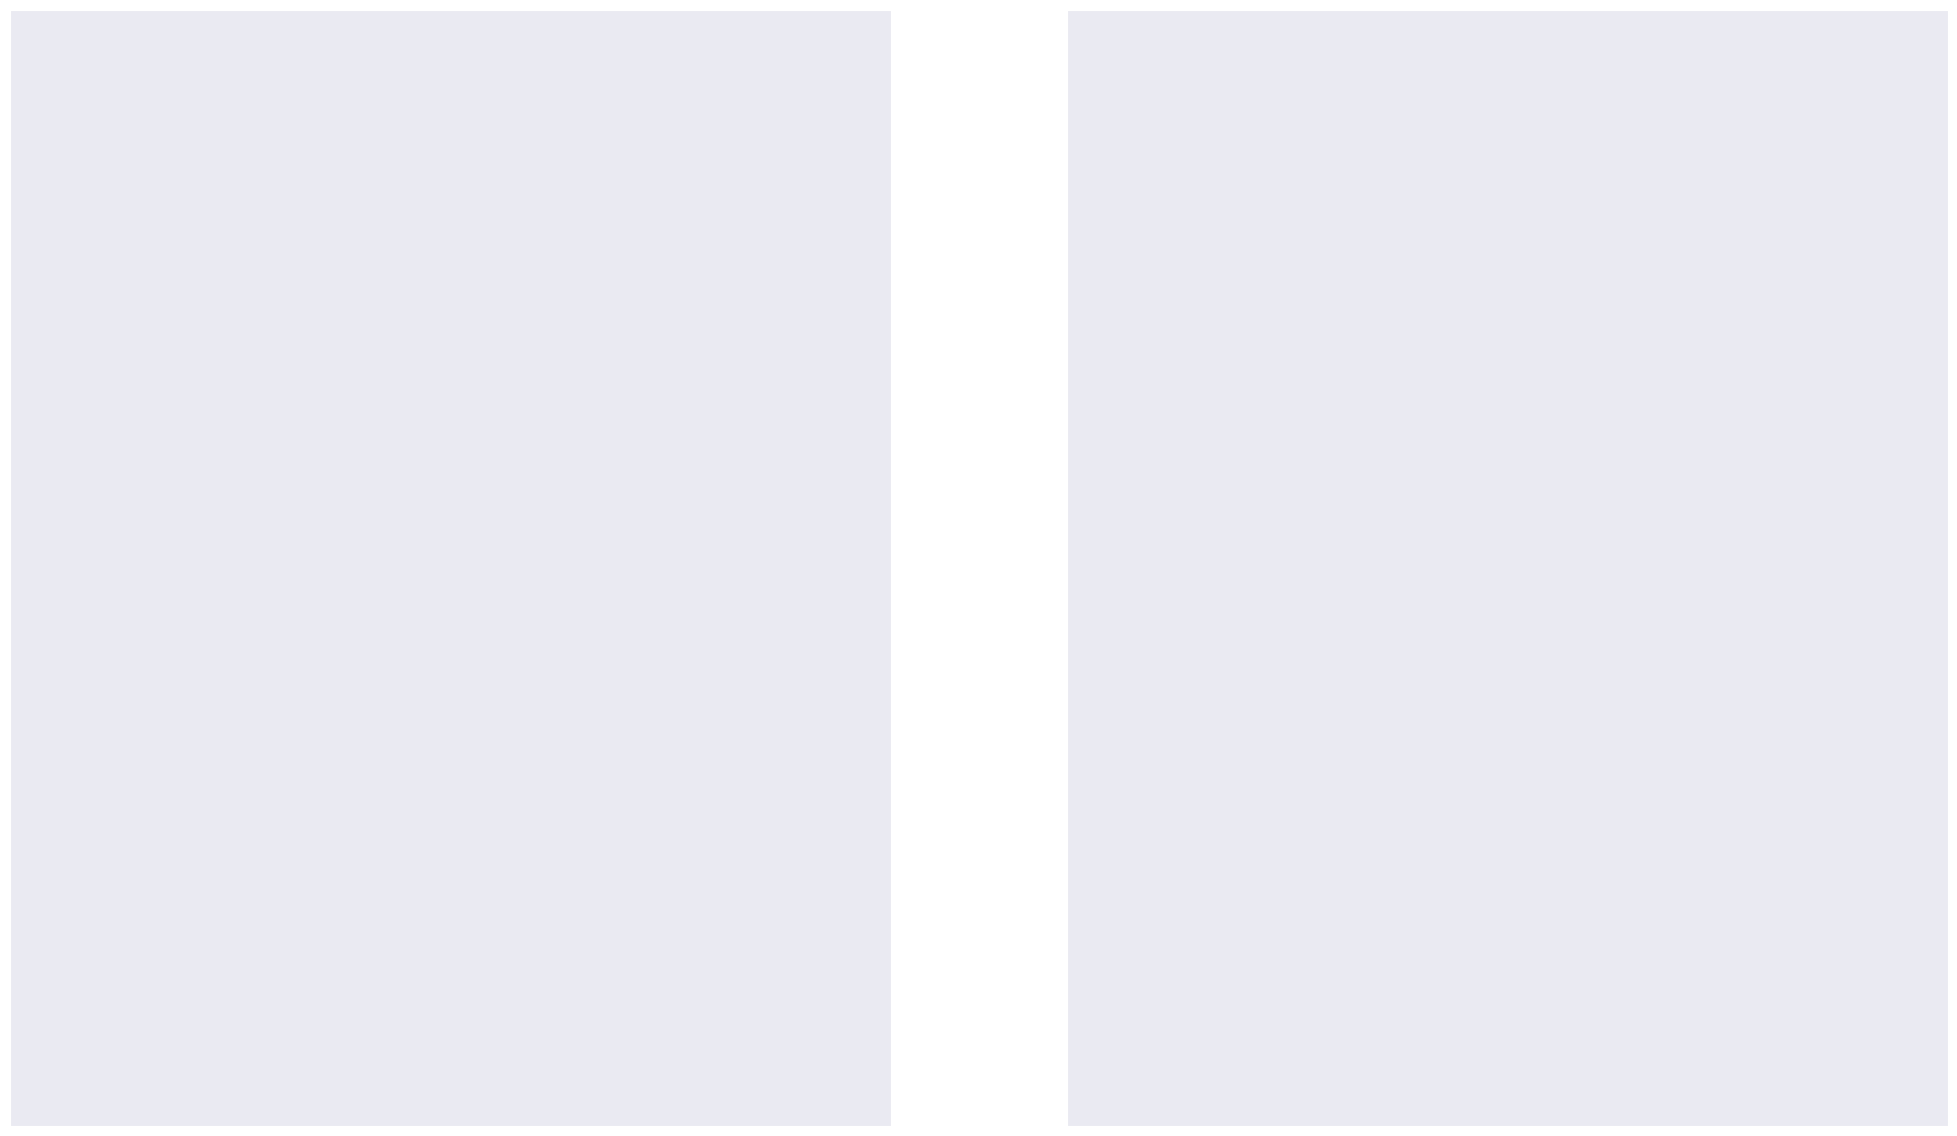

In [48]:
print(false_df.head())
plot_images(false_df,idx =[1],n_cols=2)


In [136]:
df = obj_dic_stack['train']['classification_report'].sort_values('f1-score')
df.head()



,precision,recall,f1-score,support
GREAT XENOPS,0.925532,0.852941,0.887755,102.0
FASCIATED WREN,0.967391,0.872549,0.917526,102.0
AZARAS SPINETAIL,0.936937,0.912281,0.924444,114.0
CINNAMON ATTILA,0.879032,0.990909,0.931624,110.0
HEPATIC TANAGER,0.970297,0.899083,0.933333,109.0


# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [137]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [138]:
# # Display the part of the pictures used by the neural network to classify the pictures
# obj_dic = test_obj_dic
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})
# random_index = np.random.randint(0, len(obj_dic['df']) - 1, 15)

# for i, ax in enumerate(axes.flat):
#     img_path = obj_dic['df'].Filepath.iloc[random_index[i]]
#     img_array = preprocess_input(get_img_array(img_path, size=img_size))
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     cam_path = save_and_display_gradcam(img_path, heatmap)
#     ax.imshow(plt.imread(cam_path))
#     ax.set_title(f"True: {obj_dic['df'].label.iloc[random_index[i]]}\nPredicted: {obj_dic['df'].predicted_label.iloc[random_index[i]]}")
# plt.tight_layout()
# plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>